### Q. mnist, fmnist, cifar10 순으로 간단한 CNN 모델의 성능(정확도)이 낮아지는 이유
- mnist : 60,000개의 28x28 grayscale trainset,  10,000개의 testset
- fmnist : 60,000개의 28x28 grayscale trainset,  10,000개의 testset
- cifar10 : 50,000개의 32x32 rgbcolor 이미지, 10개 범주의 라벨 trainset, 10,000개의 testset

=> 이미지 사이즈는 늘어나고 데이터 개수는 줄어들면서 성능이 낮아진다

# **CNN model of cifar-10 dataset**

### CIFAR-10 Dataset (CIFAR: Canadian Institute For Advanced Research)
> https://www.cs.toronto.edu/~kriz/cifar.html

- (50000, 32, 32, 3), train
- (10000, 32, 32, 3), test
- color photographs of objects from 10 classes, such as frogs, birds, cats, ships, etc
> class names
> - ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

tf.random.set_seed(0)

print(tf.__version__)

2.3.0


In [2]:
from tensorflow.keras import layers, models, callbacks
from keras.datasets import cifar10
from keras.utils import np_utils

# Display images in CIFAR-10
- 16 representative images

170500096/170498071 [==============================] - 2s 0us/step


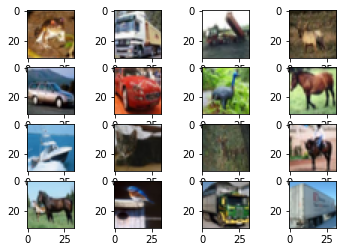

In [3]:
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(Image.fromarray(X[k].astype('uint8')))
            k = k+1
    # show the plot
    plt.show()

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_train[:16])

# Regularization

In [4]:
# 훈련셋과 시험셋 로딩 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [5]:
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [6]:
# 라벨링 전환
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

# Design CNN Model
### Neural Network Architecture

![cnn.png](https://github.com/dasdasqs2/pdm05/raw/master/py-tensorflow/final-notebook/cnn.png)

In [7]:
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from keras import regularizers, optimizers

In [8]:
# 모델 구성
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [10]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [11]:
batch_size = 64
opt_rms = keras.optimizers.RMSprop(lr=0.001,decay=1e-6)

In [12]:
cp_callback = callbacks.ModelCheckpoint(filepath="./cifar10_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=100)

In [13]:
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])

In [14]:
# training
epochs = 125
hist = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=x_train.shape[0]
                     // batch_size, epochs=epochs, verbose=1, callbacks=[cp_callback, es_callback], validation_data=(x_test,y_test))
                    

Epoch 1/125
781/781 [==============================] - 28s 35ms/step - loss: 1.9256 - accuracy: 0.4191 - val_loss: 1.3740 - val_accuracy: 0.5656
Epoch 2/125
781/781 [==============================] - 27s 34ms/step - loss: 1.3142 - accuracy: 0.5855 - val_loss: 1.1904 - val_accuracy: 0.6532
Epoch 3/125
781/781 [==============================] - 27s 34ms/step - loss: 1.1087 - accuracy: 0.6499 - val_loss: 1.1222 - val_accuracy: 0.6625
Epoch 4/125
781/781 [==============================] - 27s 34ms/step - loss: 1.0000 - accuracy: 0.6887 - val_loss: 0.9891 - val_accuracy: 0.7035
Epoch 5/125
781/781 [==============================] - 27s 34ms/step - loss: 0.9337 - accuracy: 0.7093 - val_loss: 1.0298 - val_accuracy: 0.7137
Epoch 6/125
781/781 [==============================] - 27s 34ms/step - loss: 0.8846 - accuracy: 0.7298 - val_loss: 0.8235 - val_accuracy: 0.7559
Epoch 7/125
781/781 [==============================] - 27s 34ms/step - loss: 0.8466 - accuracy: 0.7444 - val_loss: 0.7367 - val_ac

In [16]:
model.evaluate(x_test, y_test, batch_size=125, verbose=1)

80/80 [==============================] - 1s 6ms/step - loss: 0.5569 - accuracy: 0.8668


[0.5568777322769165, 0.8668000102043152]

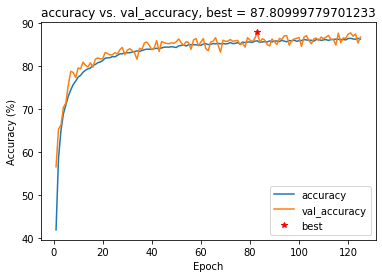

In [21]:
epochs = 125

acc_list = [100 * i for i in hist.history['accuracy']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]
loss_list = hist.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = hist.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(range(1,epochs+1),acc_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*') 
plt.title('accuracy vs. val_accuracy, best = ' +str(vacc_list[np.argmax(np.array(vacc_list))]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'])

# Save Model

In [20]:
from keras.models import load_model

model = load_model('cifar10_best_weights.083-0.8781.hdf5')
model.evaluate(x_test, y_test, batch_size=32)

313/313 [==============================] - 1s 4ms/step - loss: 0.5326 - accuracy: 0.8781


[0.5325610041618347, 0.8780999779701233]

# Test Result

In [53]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [54]:
prediction = np.argmax(model.predict(x_test[:16]),1)

['cat', 'ship', 'automobile', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship']


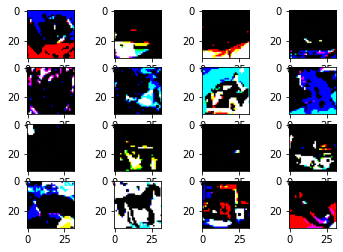

In [55]:
print([labels[x] for x in prediction])

show_imgs(x_test[:16])
